# ENEE704 Project \# 2
Nevo Magnezi

In [1]:
using DataStructures

const kB = 1.38064852e-23 #J/K
const ρ = 2.33*1e-3/((1e-2)^3) # kg/m^3
const m0 = 9.109e-31 # kg
const eV = 1.602e-19 # J
const q= eV
const ml = 0.98*m0 # Kg
const mt = 0.19*m0 # kg
const D_ac = 9*eV # J
const α = 0.5 / eV # J^-1
const vsound = 9e5*1e-2 # m/s
const T_op_g = [140, 215, 720] # K
const T_op_f = [220, 550, 685]  # K
const DtK_g =  eV*1e8/1e-2 * [0.5, 0.8, 11] # J/m
const DtK_f =  eV*1e8/1e-2 * [0.3, 2, 2] # J/m
const meff = 3/(1/ml + 2/mt) #kg
const md = (ml*mt^2)^(1/3) # kg
const ħ = 1.054e-34 # J-s

1.054e-34

In [2]:
##### Utility Functions 

# Calculuates acoustic scattering given energy and temperature
acoustic_scattering(E, T) = ((2^0.5 * md^1.5 * kB*T * D_ac^2 * (E + α*E^2)^0.5 * (1 + 2*α*E) / (π * ħ^4 * vsound^2 * ρ)), E)

acoustic_scattering (generic function with 1 method)

In [3]:
# Calculuates optical scattering given energy and temperature, as well as
# scattering paramets that determine the type of scattering
function optical_scattering(E, T_op, DtK, T; absorption=true, g_mechanism=true)
    Z = g_mechanism ? 1 : 4
    E_op = kB*T_op
    newE = E + ( absorption ? E_op : -E_op)
    if newE > 0
        E = newE
        N_op = (exp(T_op/T) - 1)^-1
        S_op = (DtK)^2*md^1.5*Z * (E + α*E^2 + 0im)^0.5 * (1 + 2*α*E) /( (√2)*π*ρ*ħ^2 * E_op)
        S_op *= ( absorption ? N_op : N_op + 1 )
    else
        S_op = 0
    end
    return (S_op, E)
end

optical_scattering (generic function with 1 method)

In [4]:
# Calculates all scattering rates and energies for all 13 scattering types
function calculate_scattering_rates(E, T)
	rates = Array{Float64}(undef, 13)
	newEs = Array{Float64}(undef, 13)
    for n=1:3

        rates[n],   newEs[n]   = optical_scattering(E, T_op_g[n], DtK_g[n], T, absorption=true,  g_mechanism=true)
        rates[n+3], newEs[n+3] = optical_scattering(E, T_op_f[n], DtK_f[n], T, absorption=true,  g_mechanism=false)
        rates[n+6], newEs[n+6] = optical_scattering(E, T_op_g[n], DtK_g[n], T, absorption=false, g_mechanism=true)
        rates[n+9], newEs[n+9] = optical_scattering(E, T_op_f[n], DtK_f[n], T, absorption=false, g_mechanism=false)
    end

    rates[end], newEs[end] = acoustic_scattering(E, T)
    return (rates=rates, newEs=newEs)
end

calculate_scattering_rates (generic function with 1 method)

In [5]:
# Calculates the total scattering at 2eV, which helps determine virtual
# scattering
calc_total_scatter(T::Float64; E::Float64=2*eV) = sum(calculate_scattering_rates(E, T).rates)

calc_total_scatter (generic function with 1 method)

In [6]:
# returns a vector of size 3 with kx, ky, kz
function k_vector(E)
    k = ((E*(1+ α*E) * 2 * meff)^0.5 )/ ħ
    r = rand(Float64, 2)
    ϕ = 2π*r[1]
    θ = acos(1-2*r[2])
    return @fastmath [k*sin(θ)*cos(ϕ), k*sin(θ)*sin(ϕ), k*cos(θ)]
end
    

k_vector (generic function with 1 method)

In [7]:
# returns velocity in direction of electric field
# dotting in direction of Field, [111]
velocity(E, k) = @fastmath (sum(k) *  ħ / (2*meff*(1+2*α*E)) * 3^-0.5 )

velocity (generic function with 1 method)

In [8]:
####### Monte Carlo Specific Functions and structs
#
# A single sample that keeps track of energy and velocity
struct sample
	E::Float64
	v::Float64
#	time::Float64
end


In [9]:
# A struct that contains all the parameters for a given monte carlo run, as
# well as storing a linked list of sample points
mutable struct montecarlo
	samples::Cons{Any} # LinkedList of samples
	E::Float64
	k::Array{Float64, 1}
	v::Float64
	field::Float64
	time::Float64
	dt::Float64
	max_time::Float64
	T::Float64
	total_scatter::Float64
end

In [10]:
# returns a randomly chosen energy based off of the binning method
# discussed in the powerpoint and in class
# -1 is returned for virtual scattering
function choose_scatter(mc::montecarlo)
    (rates, newEs) = calculate_scattering_rates(mc.E, mc.T)
	bins = cumsum(rates[1:13]) ./ mc.total_scatter
    r = rand(Float64)
    for n=1:13
        if r < bins[n]
           return newEs[n]
        end
    end
	return -1 
end

choose_scatter (generic function with 1 method)

In [11]:
# Randomly generates a flight time based using the method discussed in class
# Accounts for virtual scattering
gen_flight_time(mc::montecarlo) = -log(rand(Float64)) / mc.total_scatter

gen_flight_time (generic function with 1 method)

In [12]:
# Modifies E and k due to scattering and samples E and v and adds the values to the samples
# linked list in the monte carlo struct
function scatter!(mc::montecarlo)
	E = choose_scatter(mc)
	if E != -1
		mc.E = E
		mc.k = k_vector(E)
		mc.v = velocity(E, mc.k)
	end
	mc.samples = Cons(sample(mc.E, mc.v), mc.samples)
end

scatter! (generic function with 1 method)

In [13]:
# modifies E, k, and turns the clock for the duration of the drift
# samples for each duration dt
function drift!(mc::montecarlo)
    flight_time = gen_flight_time(mc)
    flight_num = convert(Int64, round(flight_time/mc.dt))
    mc.time += flight_num*mc.dt
    for i=1:flight_num
		mc.k .-= (q*mc.field*mc.dt / ħ) * 3^-.5 * ones(3)
		mc.E = ((1+4α*(ħ^2*sum(mc.k.^2)/(2*meff)))^0.5 - 1 ) / (2*α)
		mc.v = velocity(mc.E, mc.k)
		mc.samples = Cons(sample(mc.E, mc.v), mc.samples)
    end
end

drift! (generic function with 1 method)

In [14]:
# dynamically change E_max and thus virtual scattering as a function
# of field
# Simple linear function of field
calc_E_max(field) = 1.45e-26*field + 0.5*eV

calc_E_max (generic function with 1 method)

In [15]:
# initializes the montecarlo struct
function montecarlo_init(field, max_time, dt, T)
    E = 1.5*kB*T
	k = k_vector(E)
	v = velocity(E, k)
	samples = Cons(sample(E, v), nil())
	time = 0
    E_max = calc_E_max(field)
	total_scatter = calc_total_scatter(T; E=E_max)
	return montecarlo(samples, E, k, v, field, time, dt, max_time, T, total_scatter)
end

montecarlo_init (generic function with 1 method)

In [16]:
# Runs the monte carlo simulation given field, max_time, dt, and temperature, 
# returns a linked list of samples
function run_montecarlo(field, max_time, dt, T)
	mc = montecarlo_init(field, max_time, dt, T)
    while mc.time < mc.max_time
        drift!(mc)
        scatter!(mc)
     end
    return mc.samples
end

run_montecarlo (generic function with 1 method)

In [17]:
mean(A) = sum(A) ./size(A, 1);

In [37]:
using PyCall
using PyPlot
plt[:style][:use]("ggplot")
@pyimport scipy.stats as sp

In [19]:
clf()
for (j, T) in enumerate([300.0, 77.0])
    fields = [100*10^(n/8) for n=6:24] / 1e-2
    num_points = size(fields, 1)

    vs = zeros(num_points)
    Es = zeros(num_points)

    for	(i, field) in enumerate(fields)
        E_max = calc_E_max(field)
        total_scatter = calc_total_scatter(T, E=E_max)
        println("Total Scatter w/ virtual = $(total_scatter)")
        dt =  -log(0.5)/total_scatter * 5 # experimentally found to be a good value

        println("iteration $((j-1)*num_points + i) / $(num_points*2)")

        # dynamically change E_max and thus virtual scattering as a function
        # of field
     
        max_time = 1_000  * -log(0.5)/total_scatter

        # created a multiplier to get better data at low fields
        max_time *= field < 1e6 ? (field < 1e5 ? 8 : 3) : 1

        @time samples = run_montecarlo(field, max_time, dt, T)

        sampled_vs = [sample.v for sample in samples] 
        println("Points Sampled: $(size(sampled_vs, 1))")

        vs[i] = (abs(mean((sampled_vs))))
        println("Velocity = $(vs[i]) cm/s")

        sampled_Es = [sample.E for sample in samples] 
        Es[i] = mean((sampled_Es))
        println("Energy = $(Es[i]/eV) eV")
        println("")

    end

    figure(0)
    loglog(fields/100, (vs*100), label="T=$T K")
    figure(1)
    loglog(fields/100, Es/eV, label="T=$T K")

end

figure(0)
grid(true)
xlabel("E field (V/cm)")
ylabel("Velocity (cm/s)")
legend()
#    savefig("v_v_F.png"; dpi=200)


figure(1)
grid(true)
xlabel("E field (V/cm)")
ylabel("Energy (eV)")
legend()
#   savefig("E_v_F.png"; dpi=200)

ErrorException: type PyObject has no field clf

### Problem 1,2,3

My velocity versus E-field curves fit relatively well. 
the 300 K curve is less smooth at low-field falues-- there
seems to be some E-field threshold, around 500 V/cm, below which monte-carlo gives
jumpier results -- at least in my implementation. 

The velocity saturates quite close to where it should, approaching $10^7$ cm/s, however closer to $5 \times 10^6$ cm/s. 

Also, the 77 K curve is higher than the 300 K curve, as expected. 

There is some error compared to the literature, however. 

Comparing my curve to Jacobi et al [1], 
we can see that my 300 K curve is at roughly $6 \times 10^5$ cm/s velocity at $10^3$ V/cm, while
[1] shows the same curve at $2 \times 10^6$ at 300K, so there is not a perfect match. I presume this
is because I approximated effective mass as a single value and used the spherical assumption instead of 
ellipsoid. 

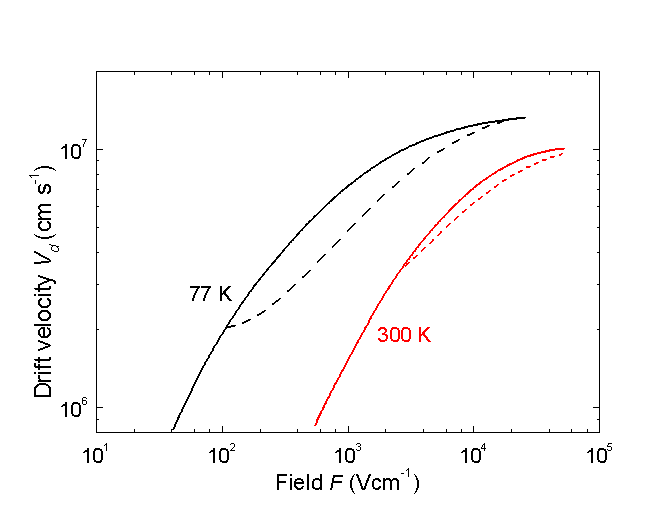

Finally, we can note a small dip in velocity towards $10^5$ E-field. If the plot was extended, it would show a much greater dip. This doesn't happen in as much in silicon (though
it does in some other elements). So either the simulation is not effective at these higher field levels (perhaps
related to the way we defined virtual scattering?), and/or at such high fields, devices turn into toasters AKA impact ionization 
which leads to Avalanche Breakdown, where electrons and holes try and ionize even more atoms and the silicon subtrate ultimately
breaks down.  These effects are not modelled in this simulator.



[1] Jacoboni, C., C. Canali, G. Ottaviani, and A. A. Quaranta, Solid State Electron. 20, 2(1977) 77-89.





iteration 1 / 5
  0.317948 seconds (945.15 k allocations: 101.261 MiB, 33.28% gc time)
Points Sampled: 115617
Average Energy = 0.3216eV

iteration 2 / 5
  0.232193 seconds (987.54 k allocations: 100.447 MiB, 15.94% gc time)
Points Sampled: 127256
Average Energy = 0.1873eV

iteration 3 / 5
  0.283500 seconds (1.09 M allocations: 106.428 MiB, 21.29% gc time)
Points Sampled: 148448
Average Energy = 0.09219eV

iteration 4 / 5
  0.256747 seconds (1.15 M allocations: 110.292 MiB, 19.38% gc time)
Points Sampled: 160148
Average Energy = 0.06187eV

iteration 5 / 5
  0.259122 seconds (1.21 M allocations: 114.907 MiB, 23.30% gc time)


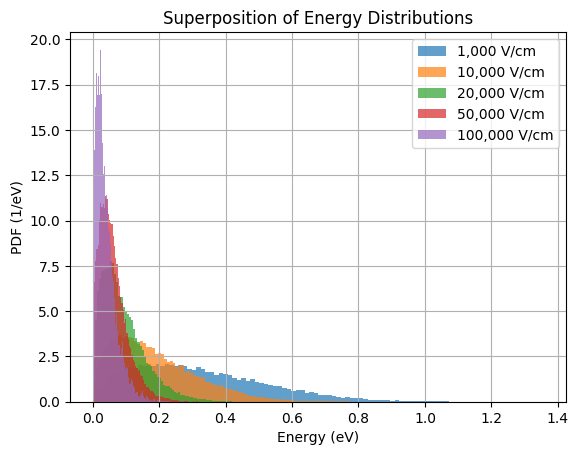

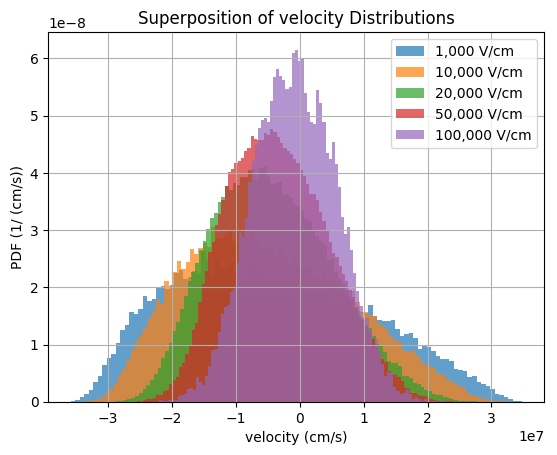

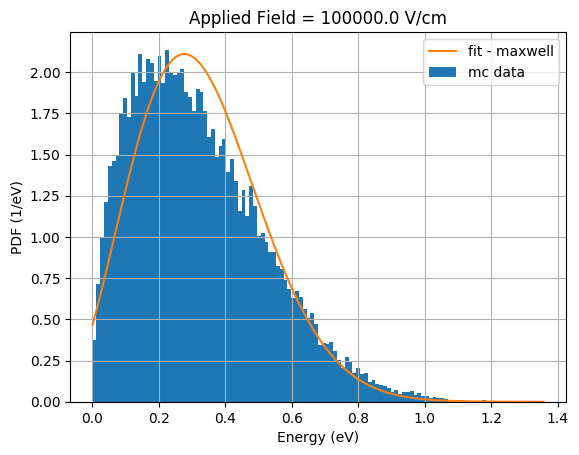

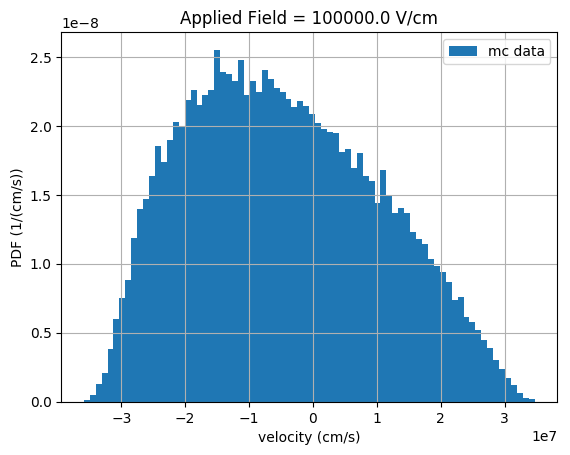

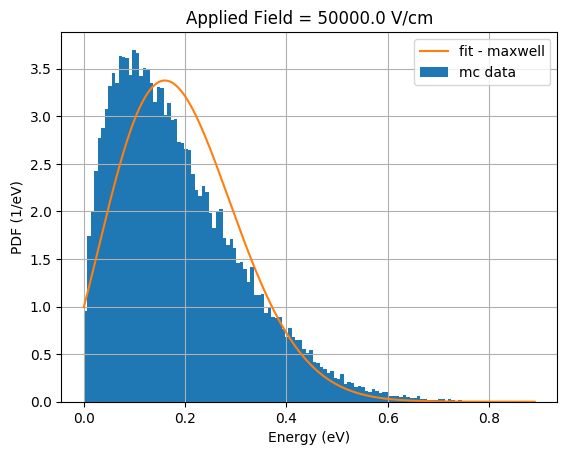

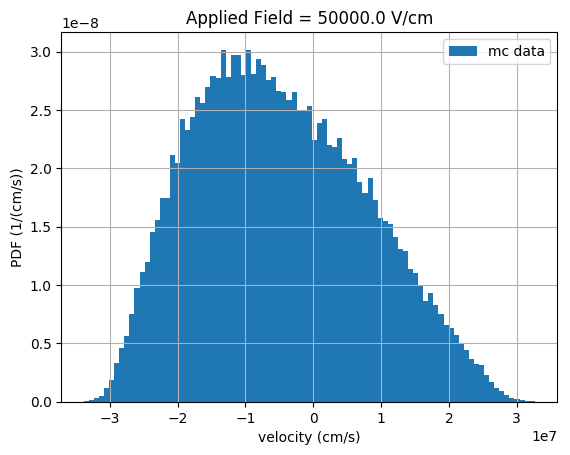

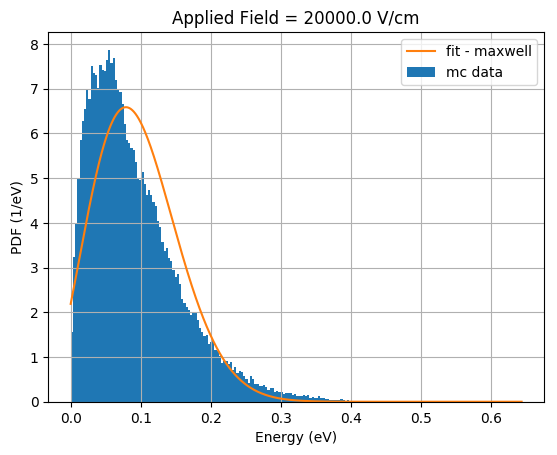

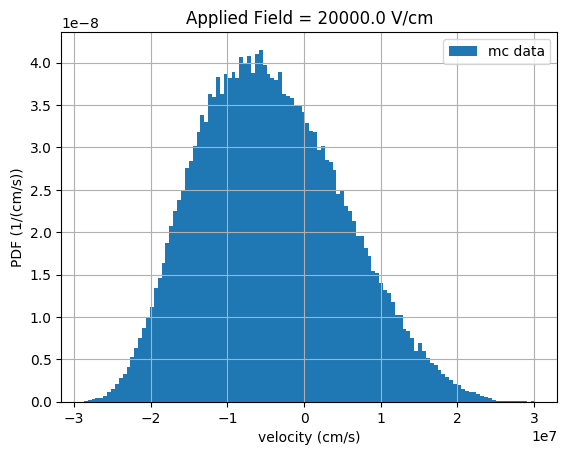

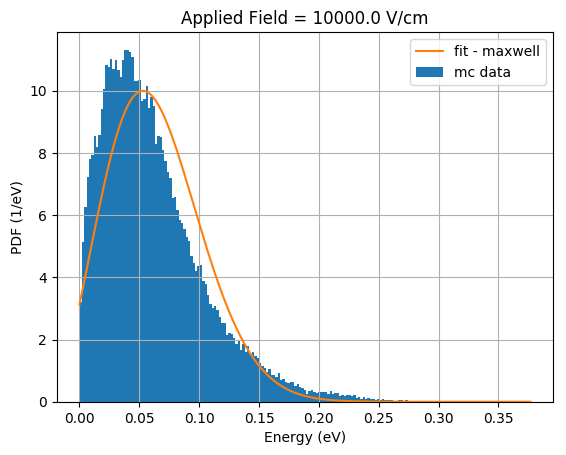

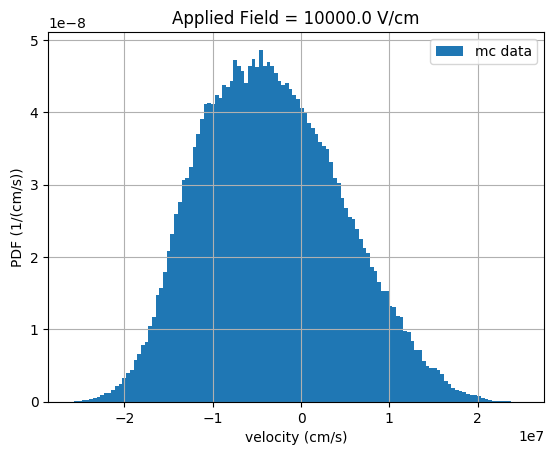

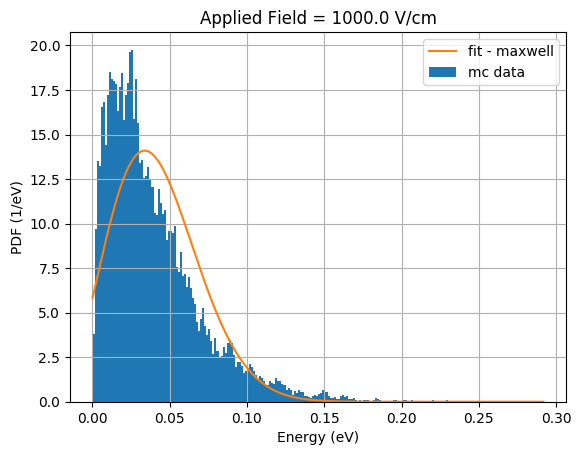

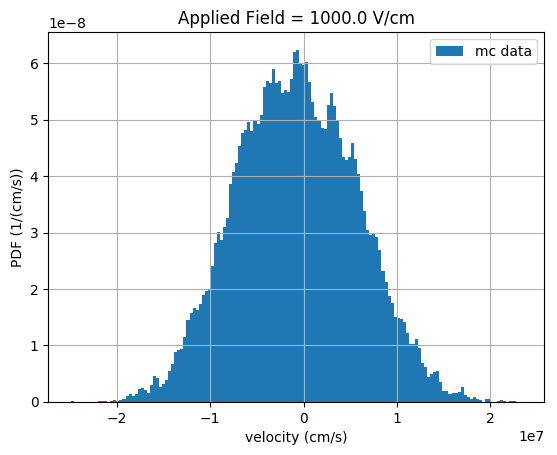

Points Sampled: 173721
Average Energy = 0.03974eV



In [26]:
function plot4()
    clf()
    fields = 1e2*reverse([1_000, 10_000, 20_000, 50_000, 100_000])
    num_plots = size(fields, 1)
    vs = zeros(num_plots)
    T= 300.0
    dt =  -log(0.5)/calc_total_scatter(T) * 5

    for (i, field) in enumerate(fields)
        println("iteration $i / $num_plots")

        E_max = calc_E_max(field)
        max_time = 100_000  * -log(0.5)/calc_total_scatter(T;E= E_max )
      
        @time samples = run_montecarlo(field, max_time, dt, T)
        vs = [100*sample.v for sample in samples]
        Es = [sample.E for sample in samples] ./ eV
        
        
        println("Points Sampled: $(size(Es, 1))")
        println("Average Energy = $(round(mean(Es),sigdigits=4))eV")
        println("")     

        num_samples = size(Es, 1)
        Es = sort(Es)
        vs = sort(vs)

        figure(1)
        plt[:hist](Es, density=1, bins=100, alpha=0.7)

        figure(2)
        plt[:hist](vs, density=1, bins=100, alpha=0.7)

        figure(2+i)

    #       a = E_avg * (π/(2^3))^0.5

        title("Applied Field = $(fields[i]/100) V/cm")
        xlabel("Energy (eV)")
        ylabel("PDF (1/eV)")
        grid(true)


        max_params = sp.maxwell[:fit](Es)
    #        norm_params = sp.norm[:fit](Es)
        E_fit = LinRange(Es[1], Es[end], num_samples)
        plt[:hist](Es, "auto", density=1, histtype="stepfilled", label="mc data")
        plot(E_fit, sp.maxwell[:pdf](E_fit, max_params...), label="fit - maxwell")
    #        plt.plot(E_fit, sp.norm[:pdf](E_fit, norm_params...), label="fit - norm")
        legend()


        figure(2 + num_plots + i)

        title("Applied Field = $(fields[i]/100) V/cm")
        xlabel("velocity (cm/s)")
        ylabel("PDF (1/(cm/s))")
        grid(true)

        plt[:hist](vs, "auto", density=1, histtype="stepfilled", label="mc data")

    #       max_params = sp.maxwell[:fit](vs)
    #       norm_params = sp.norm[:fit](vs)
        v_fit = LinRange(vs[1], vs[end], num_samples)
    #       plt.plot(v_fit, sp.maxwell[:pdf](v_fit, max_params...), label="fit - maxwell")
    #       plt.plot(v_fit, sp.norm[:pdf](v_fit, norm_params...), label="fit - norm")
        legend()

    end
    figure(1)
    legend(["1,000 V/cm", "10,000 V/cm", "20,000 V/cm",
               "50,000 V/cm", "100,000 V/cm"])
    xlabel("Energy (eV)")
    ylabel("PDF (1/eV)")
    title("Superposition of Energy Distributions")
    grid(true)
    figure(2)
    legend(["1,000 V/cm", "10,000 V/cm", "20,000 V/cm",
               "50,000 V/cm", "100,000 V/cm"])
    xlabel("velocity (cm/s)")
    ylabel("PDF (1/ (cm/s))")
    title("Superposition of velocity Distributions")
    grid(true)
    #   for i=1:12
    #        plt.figure(i)
    #        plt.savefig("fig$(i).png", dpi=200)
    #   end
end
plot4()

## Problem 4 Commentary


The maxwellian distribution somewhat fits energy data, however not particularly well. The maxwell-Boltzeman distribution overestimates, compared to monte carlo, the energy (and thus the velocity) of electrons for any given field. Additionally, for most of the fields, we can notice a tail probability that is higher with monte-carlo than with maxwell-boltzeman, indicating that, according to monte-carlo, there is a higher probability that some electrons will reach a greater energy than could be predicted my maxwell-bolzeman. Many more electrons are modelled as having lower energy for a given fields with monte carlo compared to maxwell-boltzeman, however, which we can note in the histogram heights being higher for low energies than the distribution function. 